<a href="https://colab.research.google.com/github/kinjuk/market-analysis/blob/main/qqq-macd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


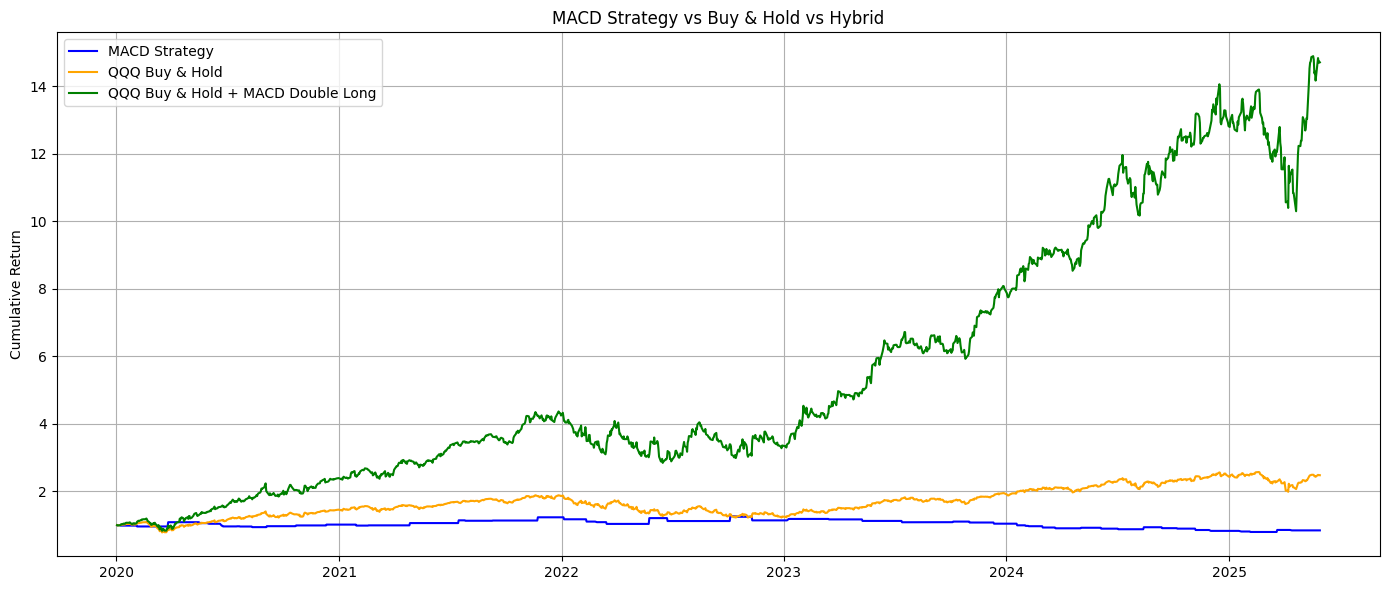

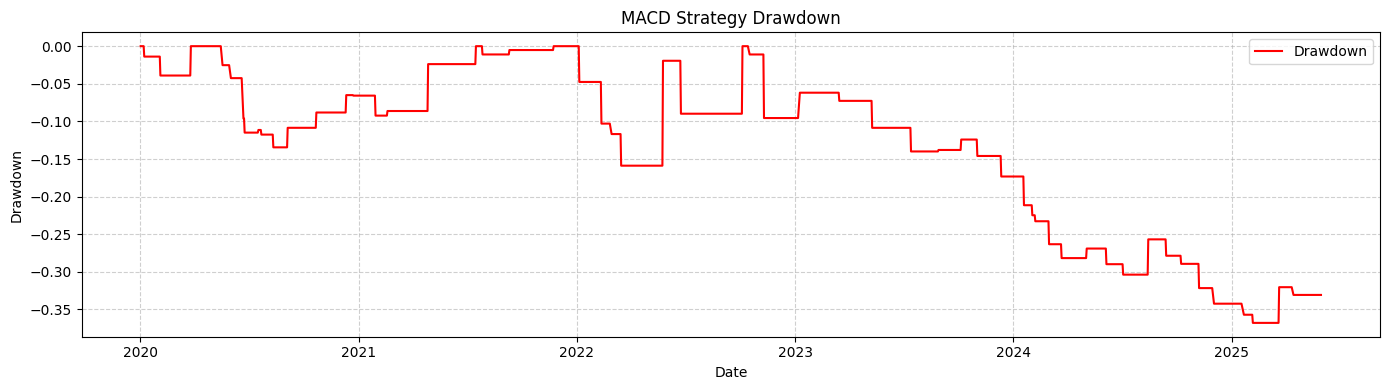


===== Strategy Performance Summary =====
Total Trades: 55
Winning Trades: 18
Losing Trades: 37
Win Rate: 32.73%
MACD Strategy Return: -15.53%
QQQ Buy & Hold Return: 147.99%
Hybrid Strategy Return: 1371.37%

Hybrid_Return descriptive statistics:
count    1360.000000
mean        0.002262
std         0.023864
min        -0.119788
25%        -0.009644
50%         0.001968
75%         0.014179
max         0.147577
Name: Hybrid_Return, dtype: float64

Largest daily returns (top 10):
Date
2022-11-10    0.147577
2020-04-06    0.142989
2025-04-09    0.120031
2020-03-26    0.105321
2022-11-30    0.091171
2020-04-14    0.086982
2020-03-13    0.084706
2022-07-27    0.084519
2025-05-12    0.081481
2020-03-24    0.077438
Name: Hybrid_Return, dtype: float64

Smallest daily returns (bottom 10):
Date
2020-03-16   -0.119788
2020-09-03   -0.101401
2020-03-12   -0.091691
2020-04-01   -0.084979
2022-02-03   -0.081088
2022-10-07   -0.076208
2020-04-21   -0.073799
2024-12-18   -0.072154
2022-06-10   -0.0705

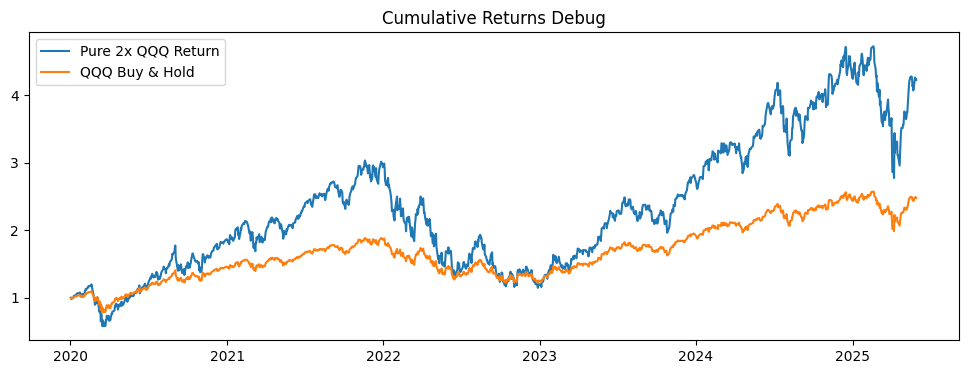

QQQ_Return descriptive statistics:
count    1360.000000
mean        0.000805
std         0.016515
min        -0.119788
25%        -0.007050
50%         0.001278
75%         0.009584
max         0.120031
Name: QQQ_Return, dtype: float64


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Parameters
START_DATE = '2020-01-01'
END_DATE = '2025-06-01'
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9
STOP_LOSS_PCT = 0.05
POSITION_SIZE = 1.0

# 2. Download QQQ
qqq = yf.download('QQQ', start=START_DATE, end=END_DATE, auto_adjust=True)
qqq = qqq[['Close']].rename(columns={'Close': 'QQQ'})
qqq.dropna(inplace=True)

# 3. MACD Calculation
ema_fast = qqq['QQQ'].ewm(span=MACD_FAST, adjust=False).mean()
ema_slow = qqq['QQQ'].ewm(span=MACD_SLOW, adjust=False).mean()
qqq['MACD'] = ema_fast - ema_slow
qqq['Signal'] = qqq['MACD'].ewm(span=MACD_SIGNAL, adjust=False).mean()

# 4. Backtest
qqq['Position'] = 0
qqq['In_Trade'] = False
qqq['Entry_Price'] = np.nan
qqq['Exit_Price'] = np.nan
qqq['Trade_Return'] = np.nan
qqq['Equity'] = np.nan

in_trade = False
position = 0
entry_price = 0
qqq.iloc[0, qqq.columns.get_loc('Equity')] = 1.0

for i in range(1, len(qqq)):
    macd_today = qqq['MACD'].iloc[i].item()
    signal_today = qqq['Signal'].iloc[i].item()
    macd_yesterday = qqq['MACD'].iloc[i - 1].item()
    signal_yesterday = qqq['Signal'].iloc[i - 1].item()
    price_today = qqq['QQQ'].iloc[i].item()
    previous_equity = qqq['Equity'].iloc[i - 1].item()

    # Crossovers
    buy_signal = macd_today > signal_today and macd_yesterday <= signal_yesterday
    sell_signal = macd_today < signal_today and macd_yesterday >= signal_yesterday

    if not in_trade:
        if buy_signal:
            position = 1
            entry_price = price_today
            qqq.iloc[i, qqq.columns.get_loc('Position')] = position
            qqq.iloc[i, qqq.columns.get_loc('Entry_Price')] = entry_price
            qqq.iloc[i, qqq.columns.get_loc('In_Trade')] = True
            in_trade = True
        elif sell_signal:
            position = -1
            entry_price = price_today
            qqq.iloc[i, qqq.columns.get_loc('Position')] = position
            qqq.iloc[i, qqq.columns.get_loc('Entry_Price')] = entry_price
            qqq.iloc[i, qqq.columns.get_loc('In_Trade')] = True
            in_trade = True
        qqq.iloc[i, qqq.columns.get_loc('Equity')] = previous_equity

    else:
        if position == 1:
            stop_loss_triggered = price_today <= entry_price * (1 - STOP_LOSS_PCT)
            exit_signal = sell_signal
        else:
            stop_loss_triggered = price_today >= entry_price * (1 + STOP_LOSS_PCT)
            exit_signal = buy_signal

        if stop_loss_triggered or exit_signal:
            trade_return = (price_today - entry_price) / entry_price if position == 1 else (entry_price - price_today) / entry_price
            new_equity = previous_equity * (1 + trade_return * POSITION_SIZE)

            qqq.iloc[i, qqq.columns.get_loc('Exit_Price')] = price_today
            qqq.iloc[i, qqq.columns.get_loc('Trade_Return')] = trade_return
            qqq.iloc[i, qqq.columns.get_loc('Equity')] = new_equity

            in_trade = False
            position = 0
            entry_price = 0
        else:
            qqq.iloc[i, qqq.columns.get_loc('Position')] = position
            qqq.iloc[i, qqq.columns.get_loc('In_Trade')] = True
            qqq.iloc[i, qqq.columns.get_loc('Equity')] = previous_equity

# Fill Equity forward
qqq['Equity'] = qqq['Equity'].ffill()

# 5. Cumulative Returns
# Base QQQ returns
qqq['QQQ_Return'] = qqq['QQQ'].pct_change().fillna(0)
qqq['QQQ_Equity'] = (1 + qqq['QQQ_Return']).cumprod()

# 6. Hybrid QQQ w/ extra long exposure when MACD Buy signal is active
qqq['Hybrid_Return'] = qqq['QQQ_Return']  # start with 1x exposure
extra_position = False

for i in range(1, len(qqq)):
    macd_today = qqq['MACD'].iloc[i].item()
    signal_today = qqq['Signal'].iloc[i].item()
    macd_yesterday = qqq['MACD'].iloc[i - 1].item()
    signal_yesterday = qqq['Signal'].iloc[i - 1].item()
    price_change = qqq['QQQ_Return'].iloc[i]

    buy_signal = macd_today > signal_today and macd_yesterday <= signal_yesterday
    sell_signal = macd_today < signal_today and macd_yesterday >= signal_yesterday

    if not extra_position:
        if buy_signal:
            extra_position = True
            # 2x exposure = 1 base + 1 extra
            qqq.iloc[i, qqq.columns.get_loc('Hybrid_Return')] = price_change * 2
        else:
            qqq.iloc[i, qqq.columns.get_loc('Hybrid_Return')] = price_change
    else:
        if sell_signal:
            extra_position = False
            qqq.iloc[i, qqq.columns.get_loc('Hybrid_Return')] = price_change
        else:
            qqq.iloc[i, qqq.columns.get_loc('Hybrid_Return')] = price_change * 2

qqq['Hybrid_Equity'] = (1 + qqq['Hybrid_Return'].fillna(0)).cumprod()


# 7. Performance Summary
trades = qqq[qqq['Trade_Return'].notna()]
total_trades = len(trades)
winning_trades = trades[trades['Trade_Return'] > 0]
losing_trades = trades[trades['Trade_Return'] <= 0]
win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
total_return = qqq['Equity'].iloc[-1] - 1
qqq_return = qqq['QQQ_Equity'].iloc[-1] - 1
hybrid_return = qqq['Hybrid_Equity'].iloc[-1] - 1

# 8. Plot Results
plt.figure(figsize=(14, 6))
plt.plot(qqq.index, qqq['Equity'], label='MACD Strategy', color='blue')
plt.plot(qqq.index, qqq['QQQ_Equity'], label='QQQ Buy & Hold', color='orange')
plt.plot(qqq.index, qqq['Hybrid_Equity'], label='QQQ Buy & Hold + MACD Double Long', color='green')
plt.title('MACD Strategy vs Buy & Hold vs Hybrid')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Drawdown
qqq['Peak'] = qqq['Equity'].cummax()
qqq['Drawdown'] = (qqq['Equity'] - qqq['Peak']) / qqq['Peak']

plt.figure(figsize=(14, 4))
plt.plot(qqq.index, qqq['Drawdown'], label='Drawdown', color='red')
plt.title('MACD Strategy Drawdown')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 10. Performance Output
print("\n===== Strategy Performance Summary =====")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {len(winning_trades)}")
print(f"Losing Trades: {len(losing_trades)}")
print(f"Win Rate: {win_rate:.2%}")
print(f"MACD Strategy Return: {total_return:.2%}")
print(f"QQQ Buy & Hold Return: {qqq_return:.2%}")
print(f"Hybrid Strategy Return: {hybrid_return:.2%}")


# debug
print("\nHybrid_Return descriptive statistics:")
print(qqq["Hybrid_Return"].describe())

print("\nLargest daily returns (top 10):")
print(qqq["Hybrid_Return"].sort_values(ascending=False).head(10))

print("\nSmallest daily returns (bottom 10):")
print(qqq["Hybrid_Return"].sort_values().head(10))

double_days = (qqq["Hybrid_Return"] == qqq["QQQ_Return"] * 2).sum()
print(f"\nNumber of doubled exposure days: {double_days}")

# plot test
qqq["Test_Double"] = (1 + qqq["QQQ_Return"] * 2).cumprod()

plt.figure(figsize=(12,4))
plt.plot(qqq.index, qqq["Test_Double"], label="Pure 2x QQQ Return")
plt.plot(qqq.index, qqq["QQQ_Equity"], label="QQQ Buy & Hold")
plt.legend()
plt.title("Cumulative Returns Debug")
plt.show()

print("QQQ_Return descriptive statistics:")
print(qqq["QQQ_Return"].describe())



